# European football leagues exploration

# Data wrangling:

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sb
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row 
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Paired
from bokeh.models import ColumnDataSource, NumeralTickFormatter, HoverTool
output_notebook()

Loading BokehJS ...

In [3]:
pd.options.display.max_rows = 200

In [4]:
pd.options.display.max_columns = 200

In [5]:
conn = sqlite3.connect('database.sqlite')

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


## Dataset structure:

**dataset consists of 7 dataframes which are:**
1) Country - dataframe with countries included in the dataset<br>
2) League - dataframe with leagues' names for each country included in the 'Country' dataframe<br>
3) Team - dataframe with teams' names<br>
4) Team_Attributes - dataframe with the attributes for each team<br>
5) Match - dataframe with the attributes for each match<br>
6) Player - dataframe with players' names and basic attributes like weight and height<br>
7) Player_Attributes - dataframe with players' football related attributes<br>

### Brief look at each table:

In [6]:
country = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [7]:
league = pd.read_sql("""SELECT *
                        FROM League;""", conn)
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [8]:
team = pd.read_sql("""SELECT *
                        FROM Team;""", conn)
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [9]:
team_attributes = pd.read_sql("""SELECT *
                        FROM Team_Attributes;""", conn)
team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [10]:
match = pd.read_sql("""SELECT *
                        FROM Match;""", conn)
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [11]:
match.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 115 columns):
 #    Column            Non-Null Count  Dtype  
---   ------            --------------  -----  
 0    id                25979 non-null  int64  
 1    country_id        25979 non-null  int64  
 2    league_id         25979 non-null  int64  
 3    season            25979 non-null  object 
 4    stage             25979 non-null  int64  
 5    date              25979 non-null  object 
 6    match_api_id      25979 non-null  int64  
 7    home_team_api_id  25979 non-null  int64  
 8    away_team_api_id  25979 non-null  int64  
 9    home_team_goal    25979 non-null  int64  
 10   away_team_goal    25979 non-null  int64  
 11   home_player_X1    24158 non-null  float64
 12   home_player_X2    24158 non-null  float64
 13   home_player_X3    24147 non-null  float64
 14   home_player_X4    24147 non-null  float64
 15   home_player_X5    24147 non-null  float64
 16   home_player_X6    24

In [12]:
player = pd.read_sql("""SELECT *
                        FROM Player;""", conn)
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [13]:
player_attributes = pd.read_sql("""SELECT *
                        FROM Player_Attributes;""", conn)
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


____________

# Part I: Goals vs Countries/Seasons correlation

## Univariate exploration

### What is the distribution of the sum of goals scored in a single match for all matches in the dataset?

- new column with sum of goals for each match

In [14]:
match['sum_of_goals'] = match['home_team_goal'] + match['away_team_goal']

- value_counts method applied for 'sum_of_goals' column

In [15]:
goals_per_match = match['sum_of_goals'].value_counts()

- series converted into dataframe

In [16]:
goals_per_match_df = pd.DataFrame(goals_per_match)

- plot creation

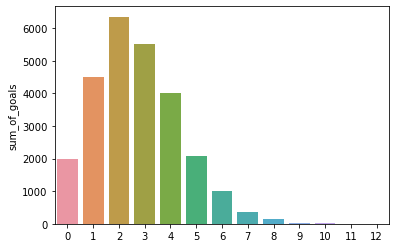

In [17]:
sb.barplot(data=goals_per_match_df, x=goals_per_match_df.index, y='sum_of_goals');

**Distribution of the sum of goals scored in a single match is right skewed with the mode equals 2 goals per match for all matches in the dataset.**

__________

## Bivariate exploration

### For all countries combined how the average number of goals scored in a single match vary accross different seasons?

- Let's make 'season' variable ordinal data type in order to make sure that it will be displayed in the right order:

In [18]:
subsequent_seasons = ['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016']
seasons = pd.api.types.CategoricalDtype(ordered=True, categories=subsequent_seasons)
match['season'] = match['season'].astype(seasons)

- calculation of average number of goals for each season

In [19]:
goals_per_season = match.groupby(['season'])['sum_of_goals'].mean()

- series converted into dataframe and column renaming from sum to average

In [20]:
goals_per_season_df = pd.DataFrame(goals_per_season)
goals_per_season_df.rename(columns={'sum_of_goals':'avg_number_of_goals'},inplace=True)

- plot creation

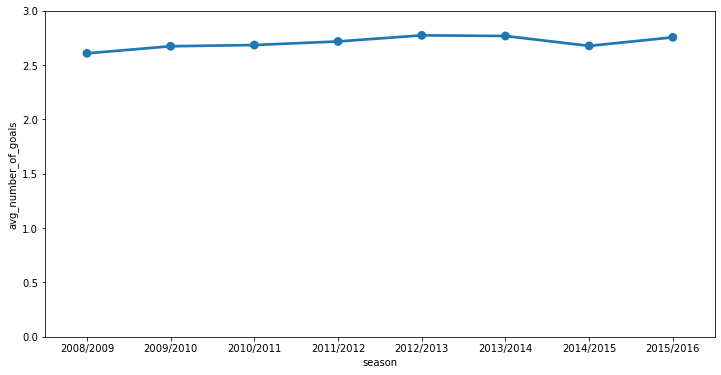

In [21]:
plt.figure(figsize = [12,6])
sb.pointplot(data=goals_per_season_df, x=goals_per_season_df.index, y='avg_number_of_goals')
plt.ylim(0,3);

In [22]:
goals_per_season_df.avg_number_of_goals.max(),goals_per_season_df.avg_number_of_goals.min()

(2.7726993865030676, 2.607336139506915)

In [23]:
(goals_per_season_df.avg_number_of_goals.max()-goals_per_season_df.avg_number_of_goals.min())/goals_per_season_df.avg_number_of_goals.min()*100

6.342229699137494

**For all countries combined the average number of goals scored in a single match vary from ~2.61 (season 2008/2009) to ~2.77 (season 2012/2013) which means that the highest value is about 6% greater than the lowest value.**

______________

### For all seasons combined how the average number of goals scored in a single match vary accross different countries?

- creation of new dataframe with both sum of goals for each match and country name where match took place

In [24]:
df_combined = match.merge(country, left_on='country_id', right_on='id', how='left')

- calculation of average number of goals for each country

In [25]:
goals_per_country = df_combined.groupby(['name'])['sum_of_goals'].mean()

- series converted into dataframe, column renaming from sum to average and sorting

In [26]:
goals_per_country_df = pd.DataFrame(goals_per_country)
goals_per_country_df.rename(columns={'sum_of_goals':'avg_number_of_goals'},inplace=True)
goals_per_country_df.sort_values(['avg_number_of_goals'],ascending=False,inplace=True)

- plot creation

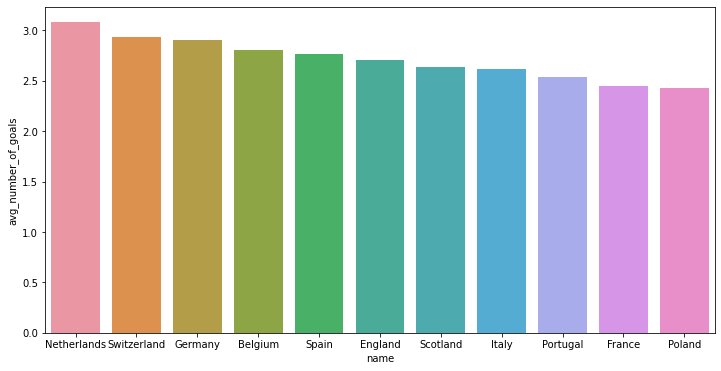

In [27]:
plt.figure(figsize = [12,6])
sb.barplot(data=goals_per_country_df, x=goals_per_country_df.index, y='avg_number_of_goals', order=goals_per_country_df.index);

In [28]:
goals_per_country_df.avg_number_of_goals.max(),goals_per_country_df.avg_number_of_goals.min()

(3.0808823529411766, 2.425)

In [29]:
(goals_per_country_df.avg_number_of_goals.max()-goals_per_country_df.avg_number_of_goals.min())/goals_per_country_df.avg_number_of_goals.min()*100

27.046694966646466

**For all seasons combined the average number of goals scored in a single match vary from ~2.43 (Poland) to ~3.08 (Netherlands) which means that the highest value is about 27% greater than the lowest value.**

_____________

## Multivariate exploration

### How the average number of goals scored in a single match vary accross different countries and different seasons?

- plot creation

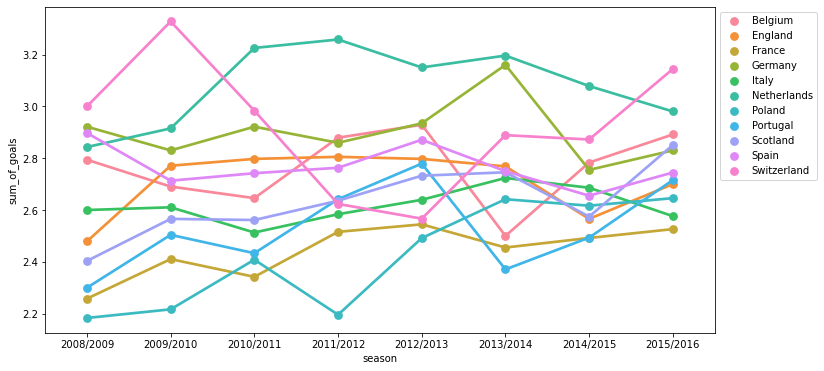

In [30]:
plt.figure(figsize = [12,6])
ax = sb.pointplot(data = df_combined, x = 'season', y = 'sum_of_goals', ci=0, hue = 'name')
ax.legend(bbox_to_anchor= (1,1));

**Average number of goals accross different countries seams to vary more at the beginning of the period we analyze and less at the end of that period.** 

_____________

# Part II: Teams vs scored/conceded goals

## Multivariate exploration

### How the particular teams perform in regards to the number of scored and conceded goals in season 2015/2016?

Since some teams have not played accross all seasons (they were degraded or upgraded in the meantime) I will compare scored and conceded goals in season 2015/2016 only.

- let's add information about teams' name and country to the 'match' dataframe

In [31]:
matches_countries_clubs = match.merge(country, left_on='country_id', right_on='id', how='left').merge(team, left_on='home_team_api_id', right_on='team_api_id')

- let's create a separate dataframe with matches' results in season 2015/2016 only

In [32]:
matches_2015_2016 = matches_countries_clubs[matches_countries_clubs['season']=="2015/2016"]

- let's calculate the number of scored and conceded goals by each home team

In [33]:
teams_performance_2015_2016_home = matches_2015_2016.groupby(['home_team_api_id','name','team_long_name']).sum()[['home_team_goal', 'away_team_goal']]
teams_performance_2015_2016_home.reset_index(inplace=True)
teams_performance_2015_2016_home.head(1)

,home_team_api_id,name,team_long_name,home_team_goal,away_team_goal
0,1601,Poland,Ruch Chorzów,20,26


- let's calculate the number of scored and 
goals by each away team

In [34]:
teams_performance_2015_2016_away = matches_2015_2016.groupby('away_team_api_id').sum()[['home_team_goal', 'away_team_goal']]
teams_performance_2015_2016_away.reset_index(inplace=True)
teams_performance_2015_2016_away.head(1)

,away_team_api_id,home_team_goal,away_team_goal
0,1601,20,17


- let's merge both dataframes so we can sum up all the scored and conceded goals for each team in the season 2015/2016

In [35]:
teams_performance_2015_2016 = teams_performance_2015_2016_home.merge(teams_performance_2015_2016_away, left_on='home_team_api_id', right_on='away_team_api_id', how='left')
teams_performance_2015_2016['goals_scored'] = teams_performance_2015_2016['home_team_goal_x']+teams_performance_2015_2016['away_team_goal_y']
teams_performance_2015_2016['goals_conceded'] = teams_performance_2015_2016['away_team_goal_x']+teams_performance_2015_2016['home_team_goal_y']
teams_performance_2015_2016.rename(columns={'home_team_api_id':'team_api_id'},inplace=True)
teams_performance_2015_2016 = teams_performance_2015_2016[['team_api_id','name','team_long_name','goals_scored','goals_conceded']]
teams_performance_2015_2016.head(1)

,team_api_id,name,team_long_name,goals_scored,goals_conceded
0,1601,Poland,Ruch Chorzów,37,46


In [36]:
index_cmap = factor_cmap('name', palette=Paired[11], 
                         factors=teams_performance_2015_2016.name.unique())

p = figure(plot_width=950, plot_height=650, title = "goals scored vs conceded")
p.scatter('goals_scored','goals_conceded',source=teams_performance_2015_2016, fill_alpha=1, fill_color=index_cmap, size=15, legend_field='name')

p.xaxis.axis_label = 'number of goals scored'
p.yaxis.axis_label = 'number of goals conceded'
p.legend.location = "top_right"
p.legend.title = "Countries"
p.legend.label_text_font_size = "16px"
p.title.text_font_size = "20px"
p.xaxis.axis_label_text_font_size = '15pt'
p.yaxis.axis_label_text_font_size = '15pt'

tooltips = [("name", "@name"), ("team_long_name", "@team_long_name"), ("goals_scored","@goals_scored"), ("goals_conceded","@goals_conceded")]
p.add_tools(HoverTool(tooltips=tooltips))

show(p)

In [37]:
corr_coefficient = teams_performance_2015_2016['goals_scored'].corr(teams_performance_2015_2016['goals_conceded'])
corr_coefficient

-0.4684938669083544

**In season 2015/2016 number of goals scored and conceded for particular club have weak (0.3 < r <0.5) negative linear relationship.**

**Additionally in season 2015/2016:**
- FC Barcelona, Real Madrid and Paris Saint-Germain are the only clubs that scored more than 100 goals
- FC Bayern Munich is the club which conceded the least goals in the season
- ES Troyes is the club which conceded the most goals

_______________

## Univariate exploration

### How many teams play in each league in season 2015/2016?

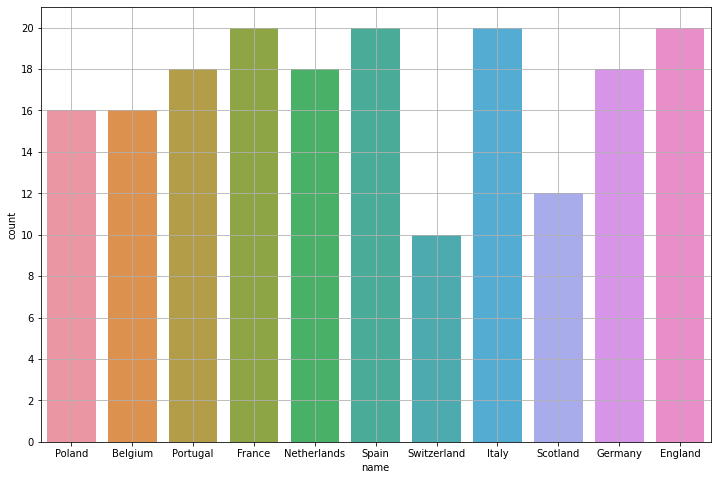

In [38]:
plt.figure(figsize = (12,8))
sb.countplot(data=teams_performance_2015_2016, x='name')
plt.yticks(np.arange(0,22,2),np.arange(0,22,2))
plt.grid();

**In Switzerland and Scotland play the least number of clubs (10 and 12 respectively).<br>
In France, Spain, Italy and England play the highest number of clubs (20).**

___________

# Part III: Teams' attributes vs how the teams perform

I would like to verify how the teams' attributes correlate with the number of scored and conceded goals.<br>
Since teams' attributes vary accross different seasons I will focus on season 2015/2016.

- list of clubs that played in season 2015/2016

In [39]:
list_of_clubs = teams_performance_2015_2016['team_api_id'].tolist()
list_of_clubs

[1601,
 1773,
 1957,
 2182,
 2186,
 6367,
 6391,
 6403,
 6413,
 7788,
 7794,
 7819,
 7841,
 7842,
 7844,
 7878,
 7896,
 7943,
 8019,
 8020,
 8021,
 8023,
 8025,
 8028,
 8030,
 8033,
 8066,
 8121,
 8177,
 8178,
 8197,
 8203,
 8226,
 8234,
 8245,
 8262,
 8277,
 8284,
 8302,
 8305,
 8306,
 8315,
 8342,
 8348,
 8370,
 8372,
 8406,
 8426,
 8429,
 8455,
 8456,
 8464,
 8466,
 8467,
 8472,
 8475,
 8485,
 8524,
 8525,
 8526,
 8533,
 8534,
 8535,
 8540,
 8543,
 8558,
 8560,
 8564,
 8571,
 8573,
 8581,
 8586,
 8592,
 8593,
 8597,
 8600,
 8603,
 8611,
 8613,
 8633,
 8634,
 8635,
 8636,
 8639,
 8640,
 8649,
 8650,
 8654,
 8659,
 8668,
 8673,
 8674,
 8678,
 8686,
 8689,
 8697,
 8721,
 8722,
 9747,
 9748,
 9768,
 9772,
 9773,
 9783,
 9788,
 9789,
 9790,
 9791,
 9803,
 9804,
 9807,
 9810,
 9817,
 9823,
 9824,
 9825,
 9826,
 9827,
 9829,
 9830,
 9831,
 9837,
 9847,
 9850,
 9851,
 9853,
 9857,
 9860,
 9864,
 9869,
 9875,
 9876,
 9882,
 9885,
 9891,
 9904,
 9905,
 9906,
 9908,
 9910,
 9925,
 9927,
 9931,

- let's create a separate dataframe with teams' attributes for season 2015/2016

In [40]:
team_attributes_2015_2016 = team_attributes[team_attributes['date']=='2015-09-10 00:00:00']
team_attributes_2015_2016 = team_attributes_2015_2016[team_attributes_2015_2016['team_api_id'].isin(list_of_clubs)]

___________

## Univariate exploration

### What is the distribution of teams' attributes?

In [41]:
attributes = ['buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing','chanceCreationPassing','chanceCreationCrossing','chanceCreationShooting','defencePressure','defenceAggression','defenceTeamWidth']

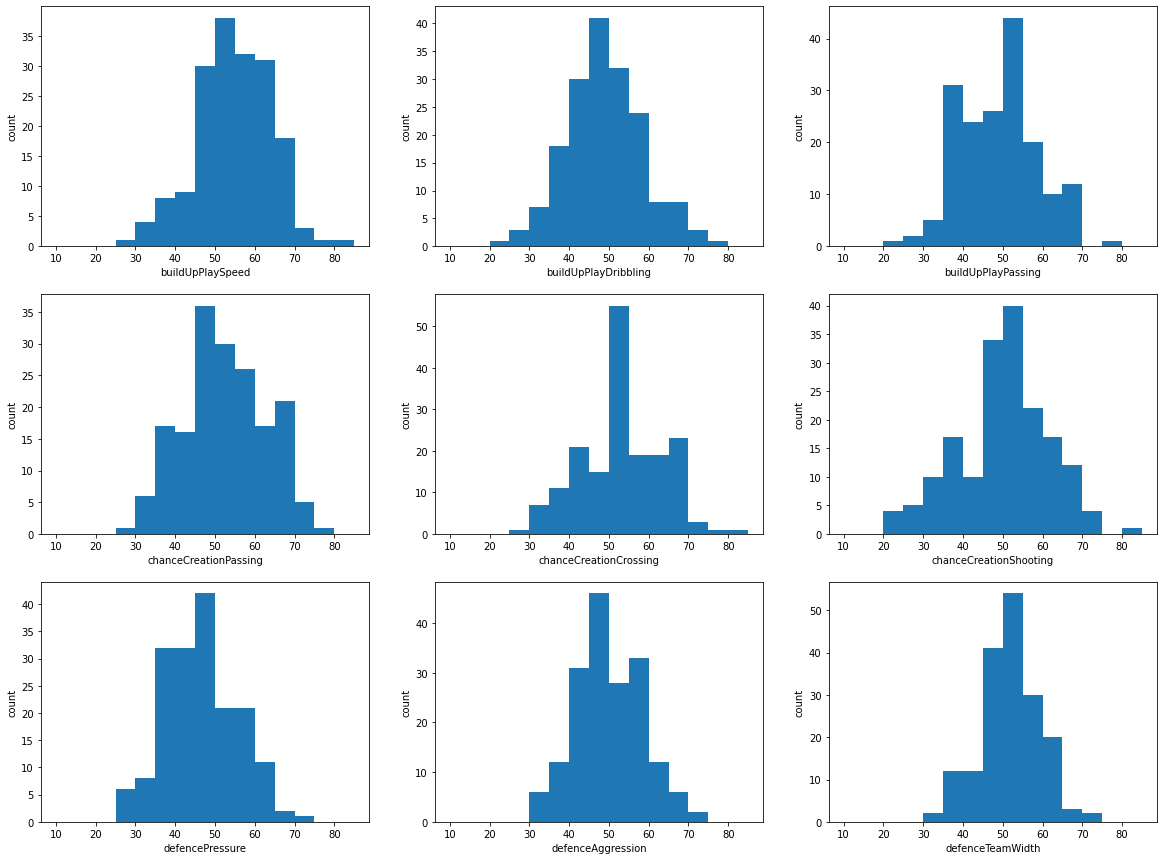

In [42]:
plt.figure(figsize = [20, 15])
bins = np.arange(10,90,5)

for i,j in enumerate(attributes):
    plt.subplot(3, 3, i+1)
    plt.hist(data=team_attributes_2015_2016, x=attributes[i], bins = bins)
    plt.xlabel(attributes[i])
    plt.ylabel('count')

**All attributes' distributions are similar to normal distribution.**

___________

## Bivariate exploration

### How teams' attributes are correlated with each other?

- let's create scatter and heat matrix for all attributes

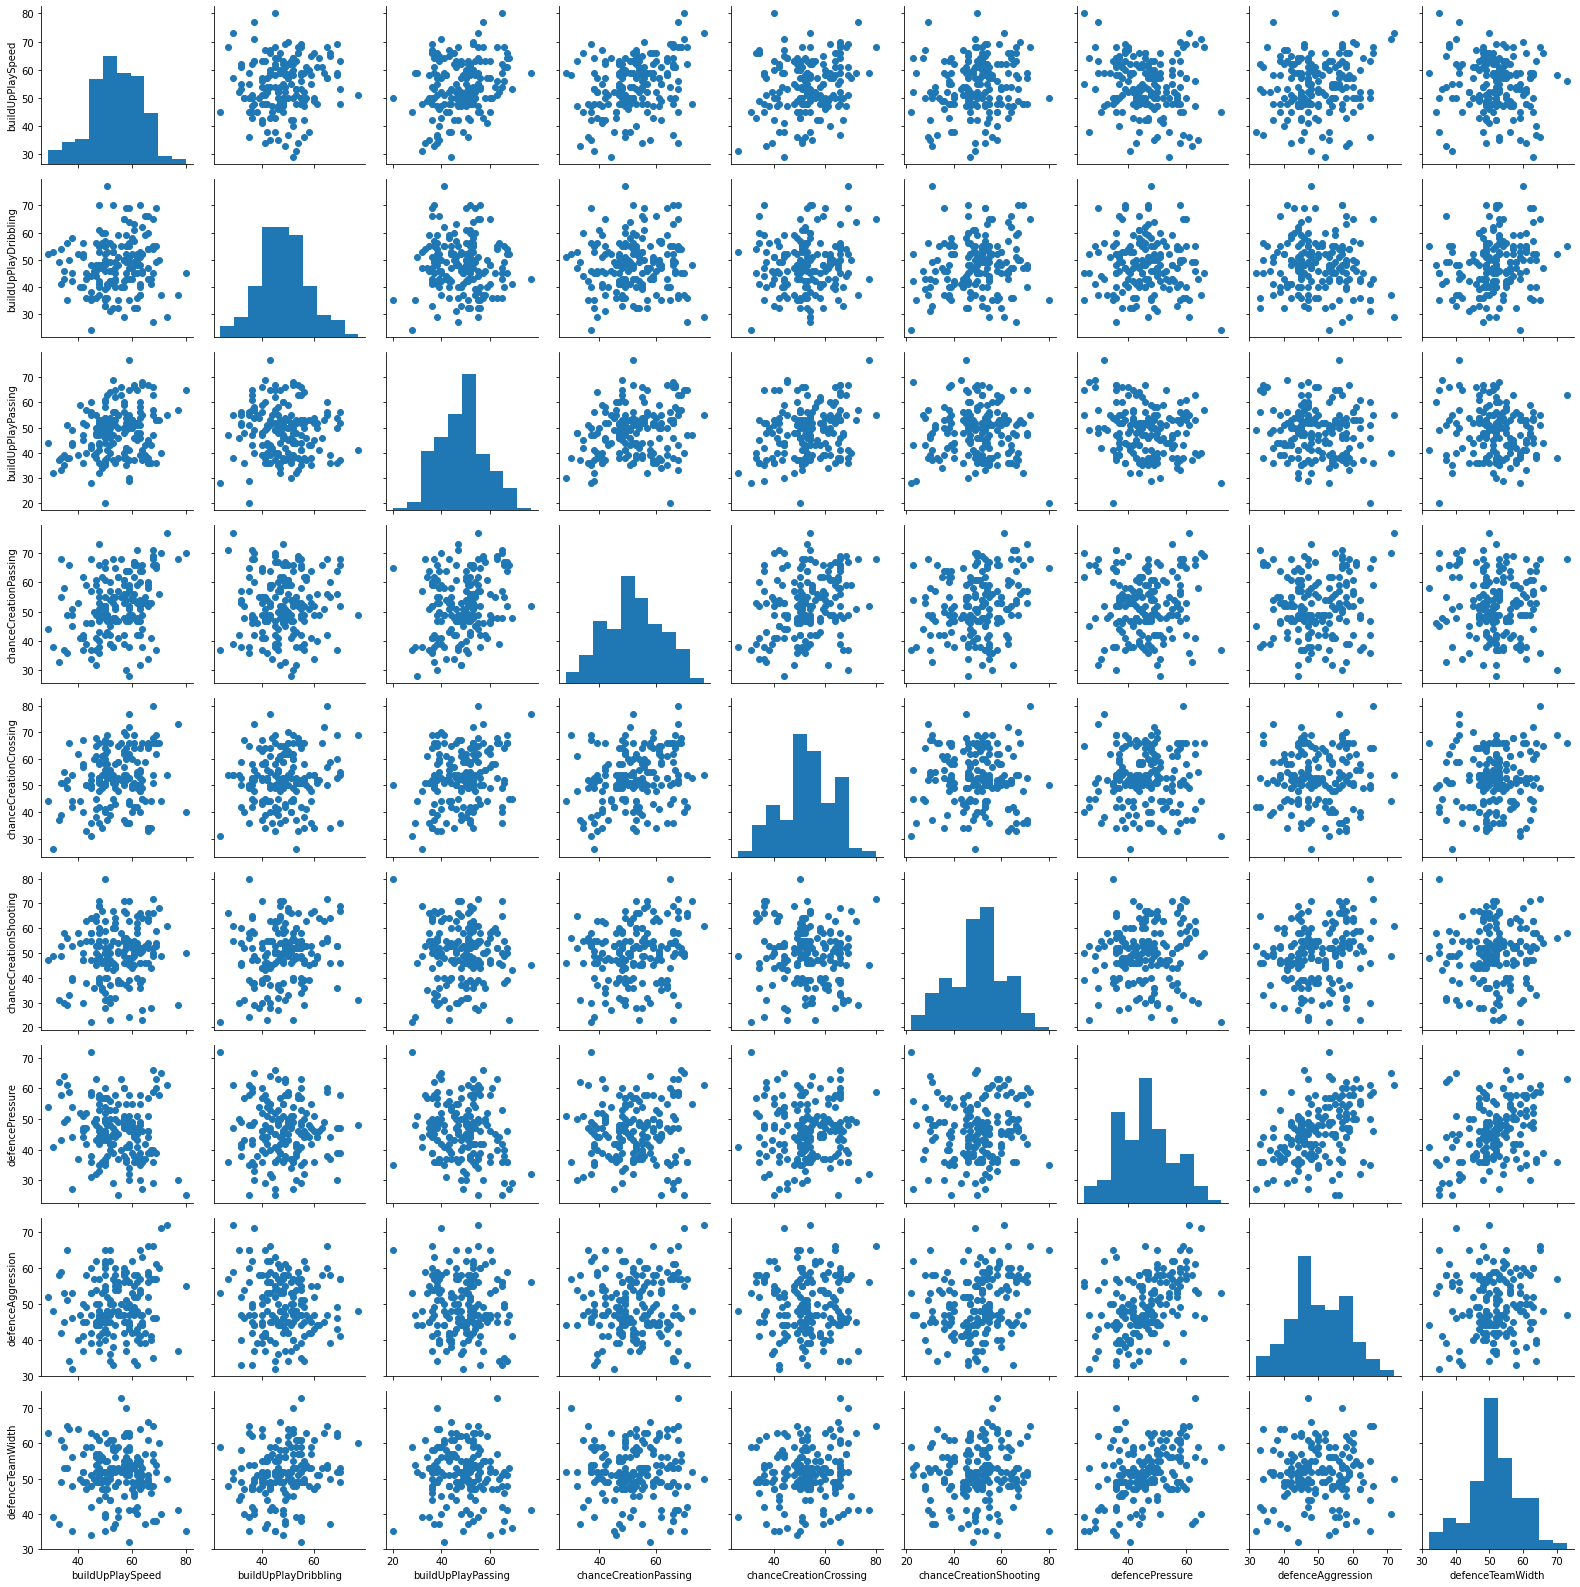

In [43]:
g = sb.PairGrid(data=team_attributes_2015_2016, vars=attributes)
g.map_offdiag(plt.scatter)
g.map_diag(plt.hist);

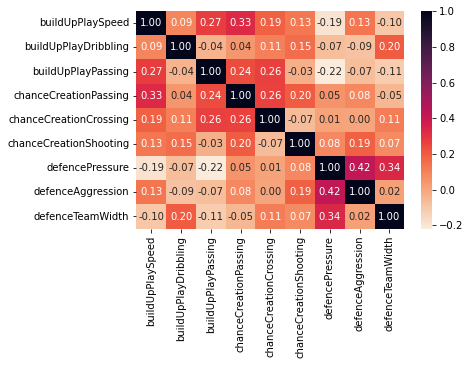

In [44]:
sb.heatmap(team_attributes_2015_2016[attributes].corr(), cmap='rocket_r', annot=True, fmt='.2f');

**the following pairs of attributes have weak (0.3 < r <0.5) positive linear relationship:**<br>
- chance creation passing - build up play speed<br>
- defence team width - defence pressure<br>
- defence aggression - defence pressure

_______________

### How teams' attributes are correlated with the number of scored and conceded goals?

- let's merge dataframe with the number of scored and conceded goals in the season 2015/2016 with the dataframe containing the attributes for each team 

In [45]:
teams_performance_2015_2016 = teams_performance_2015_2016.merge(team_attributes_2015_2016, left_on='team_api_id', right_on='team_api_id', how='left')

In [46]:
teams_performance_2015_2016.head(1)

,team_api_id,name,team_long_name,goals_scored,goals_conceded,id,team_fifa_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1601,Poland,Ruch Chorzów,37,46,1118.0,874.0,2015-09-10 00:00:00,47.0,Balanced,48.0,Normal,38.0,Mixed,Organised,61.0,Normal,65.0,Normal,50.0,Normal,Organised,43.0,Medium,44.0,Press,49.0,Normal,Cover


In [47]:
attributes_goals = attributes + ['goals_scored','goals_conceded']

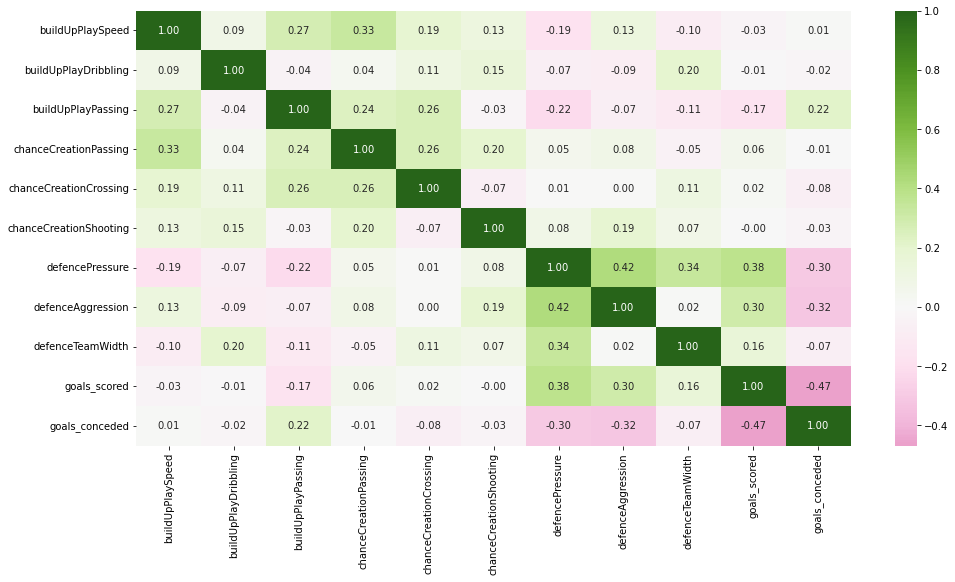

In [48]:
plt.figure(figsize = (16,8))
sb.heatmap(teams_performance_2015_2016[attributes_goals].corr(), cmap="PiYG", center=0, annot=True, fmt='.2f');

**Based on the above heat map 'defence pressure' and 'defence aggression' attributes have weak (0.3 =< r <0.5) positive linear relationship with the number of goals scored and weak negative (-0.3 >= r > -0.5) linear relationship with number of goals conceded.**

______________

# Part IV: Players' attributes distribution

## Univariate exploration

### What is the distribution of weight and height for all players?

- based on below values both height and weight attributes can be treated as quantitive discrete data

In [49]:
player.height.value_counts().count()

20

In [50]:
player.weight.value_counts().count()

50

- plot creation

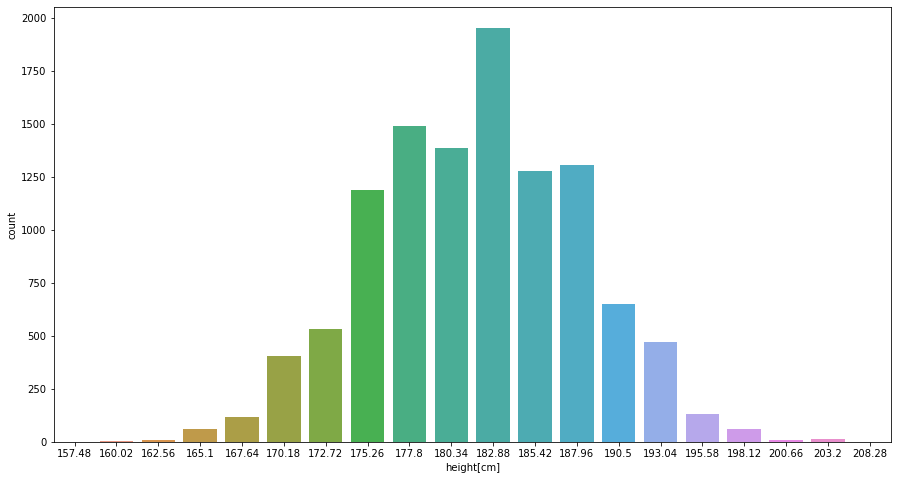

In [51]:
plt.figure(figsize = [15,8])
sb.countplot(data=player, x='height')
plt.xlabel('height[cm]');

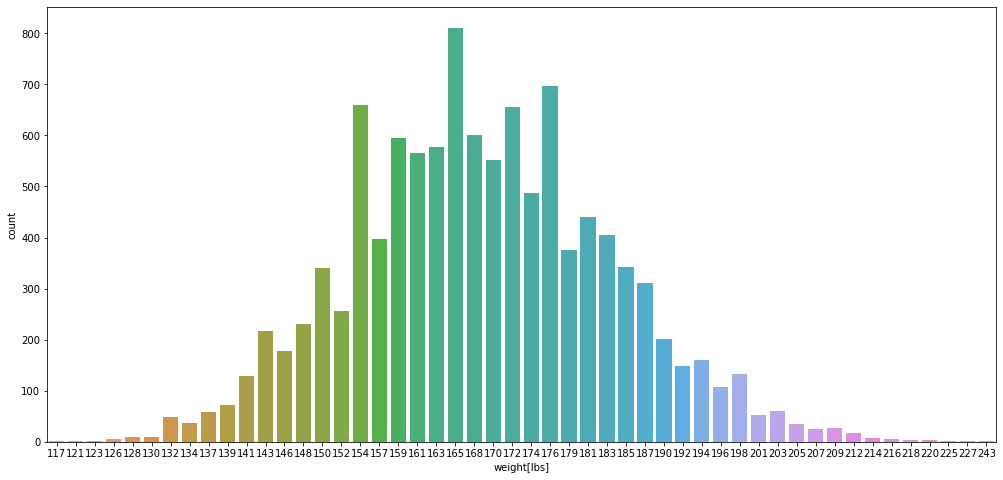

In [52]:
plt.figure(figsize = [17,8])
sb.countplot(data=player, x='weight')
plt.xlabel('weight[lbs]');

**Both weight and height attributes are normally distributed.**

___________

## Bivariate exploration

### What is the correlation between weight and height for all players?

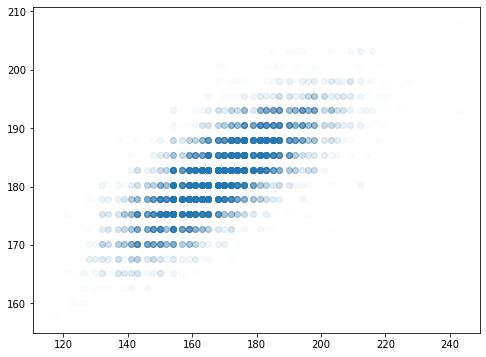

In [53]:
plt.figure(figsize = [8,6])
plt.scatter(data = player, x = 'weight', y = 'height', alpha=1/50);

**Weight and height are linearly correlated.**

_______________

# Univariate exploration

### What is the distribution of players' overall rating and potential?

- each player has different ratings in each season, I will calculate the mean ratings' values for each player

In [54]:
player_attributes_unique = player_attributes.groupby(['player_api_id'])[['overall_rating','potential']].mean()

In [55]:
player_attributes_unique = player_attributes_unique.reset_index()

- calculating the bins as max()-min() with step equals 1

In [56]:
bins_rating = np.arange(player_attributes_unique.overall_rating.min(),player_attributes_unique.overall_rating.max(),1)
bins_potential = np.arange(player_attributes_unique.potential.min(),player_attributes_unique.potential.max(),1)

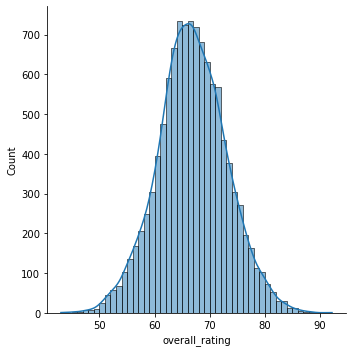

In [57]:
sb.displot(player_attributes_unique.overall_rating, bins=bins_rating, kde=True);

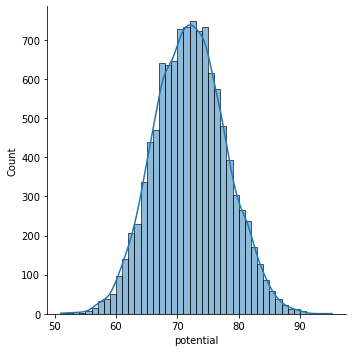

In [58]:
sb.displot(player_attributes_unique.potential, bins=bins_potential, kde=True);

**Botk overall rating and potential are normally distributed.**